In [1]:
#Import library
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from numpy import asarray
from scipy.ndimage import label, generate_binary_structure
from scipy import ndimage

import torch
from torchvision import transforms

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Change working directory
%cd /content/drive/My Drive/Colab Notebooks/TableNet OCR

/content/drive/My Drive/Colab Notebooks/TableNet OCR


In [ ]:
!ls

 column_mask					   Marmot_data
 data						   table_mask
'Exploratory Data Analysis-Marmot Dataset.ipynb'  'Tablenet Model'
 image.bmp


**Files in Dataset**

In [ ]:
COLAB_DRIVE = "/content/drive/My Drive/Colab Notebooks/TableNet OCR/"
MARMOT_DIR = f"{COLAB_DRIVE}Marmot_data/"
TABLE_DIR = f"{COLAB_DRIVE}table_mask/"
COLUMN_DIR = f"{COLAB_DRIVE}column_mask/"

In [ ]:
#Marmot_data
xml_files = [os.path.basename(x)[:-4] for x in glob.glob("Marmot_data/*.xml")]
bmp_files = [os.path.basename(x)[:-4] for x in glob.glob("Marmot_data/*.bmp")]
print(f"number of xml files: {len(xml_files)}")
print(f"number of bmp files: {len(bmp_files)}")

number of xml files: 494
number of bmp files: 509


In [ ]:
#Missing XML files in Marmot_data
missing_xml=set(bmp_files)-set(xml_files)
print(f"number of missing xml files:{len(missing_xml)}")

for i in missing_xml:
    print(i)

number of missing xml files:15
10.1.1.1.2076_73
10.1.1.160.677_2
10.1.1.100.2006_12
10.1.1.160.585_35
10.1.1.1.2107_9
10.1.1.6.2367_13
10.1.1.100.293_47
10.1.1.7.2174_3
10.1.1.7.2174_8
10.1.1.100.293_25
10.1.1.1.2010_5
10.1.1.120.1540_16
10.1.1.160.669_3
10.1.1.160.585_36
10.1.1.120.1540_21


In [ ]:
#To find out file_id
unique_filename = [filename[:-4] for filename in os.listdir("Marmot_data") if filename.endswith(".bmp")] 
print(len(unique_filename))

print(unique_filename)

509
['10.1.1.1.2107_9', '10.1.1.1.2031_24', '10.1.1.34.330_9', '10.1.1.1.2100_12', '10.1.1.1.2023_33', '10.1.1.1.2129_6', '10.1.1.1.2020_8', '10.1.1.36.8492_1', '10.1.1.6.2308_13', '10.1.1.34.3224_7', '10.1.1.34.3054_1', '10.1.1.120.1530_5', '10.1.1.100.303_8', '10.1.1.32.6167_3', '10.1.1.33.8442_11', '10.1.1.160.659_3', '10.1.1.34.330_10', '10.1.1.6.2234_17', '10.1.1.38.2480_2', '10.1.1.160.660_5', '10.1.1.6.2218_15', '10.1.1.160.659_6', '10.1.1.36.8492_3', '10.1.1.6.2215_30', '10.1.1.33.5766_4', '10.1.1.160.587_6', '10.1.1.120.1507_6', '10.1.1.100.2031_8', '10.1.1.193.1816_4', '10.1.1.160.552_18', '10.1.1.175.3005_18', '10.1.1.190.1802_6', '10.1.1.160.674_19', '10.1.1.160.529_31', '10.1.1.185.1566_14', '10.1.1.120.1603_23', '10.1.1.100.2031_11', '10.1.1.160.531_23', '10.1.1.179.3009_10', '10.1.1.160.644_112', '10.1.1.160.529_30', '10.1.1.170.1000_27', '10.1.1.193.1803_3', '10.1.1.176.3008_3', '10.1.1.175.3003_7', '10.1.1.180.559_26', '10.1.1.176.3008_16', '10.1.1.160.531_12', '10.1.1

**Check missing file_id in Column Mask**

In [ ]:
column_mask = [os.path.basename(x)[:-4] for x in glob.glob("column_mask/*.bmp")]
print(f"column_mask: {len(column_mask)}")
missing_column_mask_file_id = set(column_mask)-set(bmp_files) 
print(f"missing_column_mask_file_id: {len(missing_column_mask_file_id)}")

column_mask: 509
missing_column_mask_file_id: 0


**Check missing file_id in Table Mask**

In [ ]:
table_mask = [os.path.basename(x)[:-4] for x in glob.glob("table_mask/*.bmp")]
print(f"table_mask: {len(table_mask)}")
missing_table_mask_file_id = set(table_mask)-set(bmp_files)
print(f"missing_table_mask_file_id: {len(missing_table_mask_file_id)}")

table_mask: 509
missing_table_mask_file_id: 0


**Display first 5 sample images**

In [ ]:
def display_images(file_ids):
    """Helper function to display original document image, table and column
    images by given a list of unique file id.
    Usage example:
        └── data/
            ├── marmot_data/
            │   ├── 200_12.bmp
            │   ├── 200_12.xml
            │   ├── 200_13.bmp
            │   └── 200_13.xml
            ├── table_mask/
            │   ├── 200_12.bmp
            │   └── 200_13.bmp
            └── column_mask/
                ├── 200_12.bmp
                └── 200_13.bmp
        files_ids = ["200_12", "200_13"]
        display_images(file_ids)
        >> <2x3 subplot images>
    args:
        file_ids: List[str]
        List of str-type unique file id that exists in all three directories:
        original document image, table mask and column mask.
    """
     # setup figures
    _, axs = plt.subplots(len(file_ids), 3, figsize=(30, 30))

    # write column title
    column_titles = ["Original Image", "Table Mask", "Column Mask"]
    for ax, col in zip(axs[0], column_titles):
        ax.set_title(col)

    # collect img_paths we need
    image_paths = []
    for sample_idx, file_id in enumerate(file_ids, 0):
        marmot_path = f"{MARMOT_DIR}{file_id}" + '.bmp'
        table_path = f"{TABLE_DIR}{file_id}" + '.bmp'
        column_path = f"{COLUMN_DIR}{file_id}" + '.bmp'

        image_paths.append((marmot_path, table_path, column_path))

        # plotting
        for column_idx in range(3):
            axs[sample_idx, column_idx].imshow(Image.open(image_paths[sample_idx][column_idx]), cmap = 'gray') #using cmap to display bnw

    plt.show()

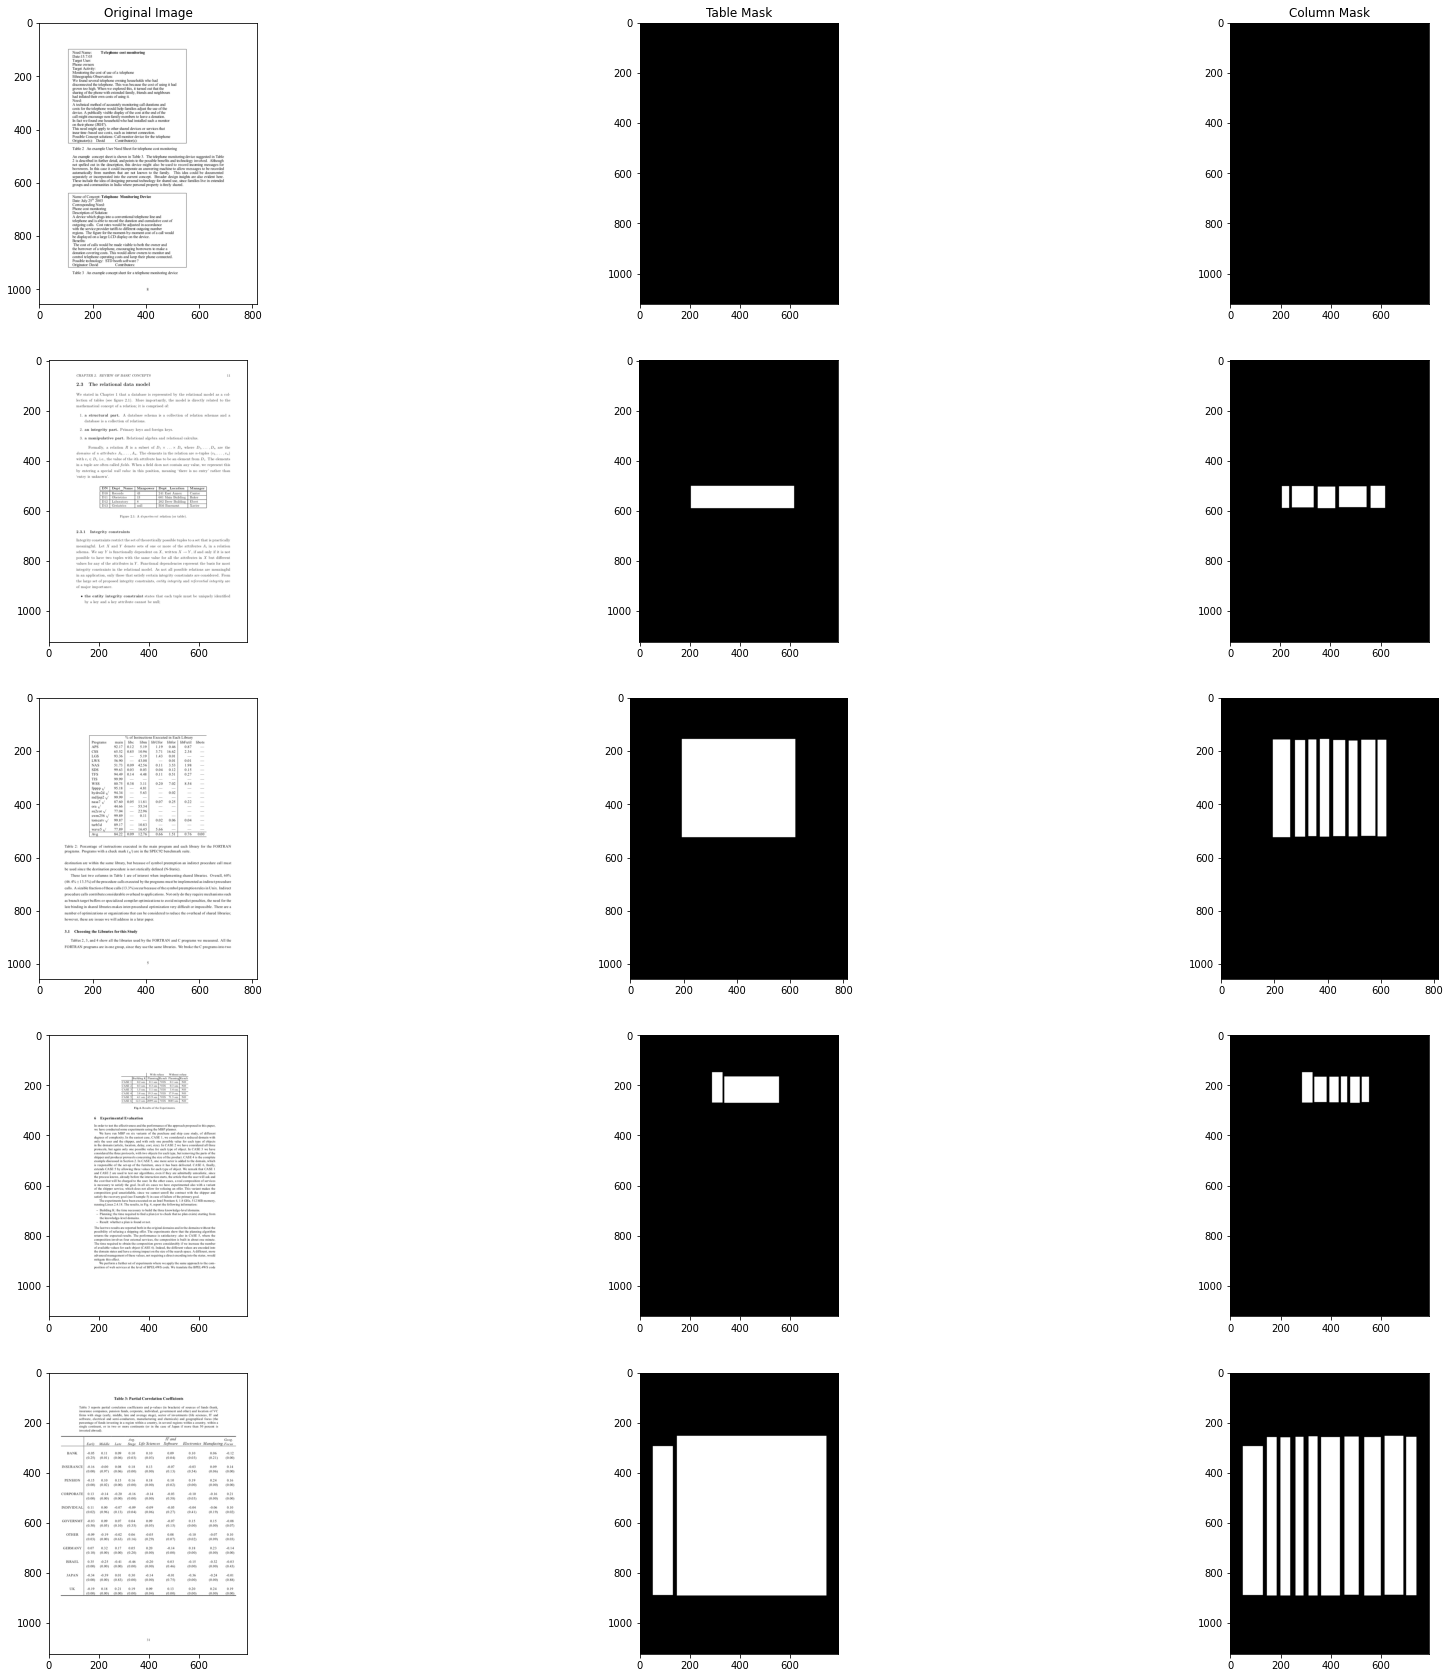

In [ ]:
display_images(unique_filename[:5])

In [ ]:
def get_table_number(file_ids):
    """
    Function to find number of tables in table_mask using scipy.ndimage by looking at the number of white regions.
    Usage example: 
        file_ids = ["10.1.1.1.2107_9","10.1.1.1.2076_73" ]
        get_table_number(file_ids)
        >> [(1, "10.1.1.1.2107_9"), 
            (2, "10.1.1.1.2076_73")
            ]
        args: 
            file_ids: List[int]
                List of unique file id
        return: 
            result_table: List[Tuple(int, str)]
                List of tuples where each tuple consists of number of tables and file_id
    """
    results_table = []
    zero_table, one_table = [], []
    
    for file_id in file_ids:
        table_path = f"{TABLE_DIR}{file_id}" + ".bmp"
        table = Image.open(table_path)
        image_array=np.array(table)
        _, num_features = label(image_array)

        results_table.append((num_features, file_id))
        
    return results_table

In [ ]:
table_results = get_table_number(unique_filename)

In [ ]:
zero_table = [file_id for num_table, file_id in table_results if num_table == 0]
one_table = [file_id for num_table, file_id in table_results if num_table == 1]
more_than_one_table = [file_id for num_table, file_id in table_results if num_table > 1]

print(f"zero_table: {len(zero_table)}")
print(f"one_table: {len(one_table)}")
print(f"more_than_one_table: {len(more_than_one_table)}")

zero_table: 15
one_table: 229
more_than_one_table: 265


**Display Top 3 images with zero tables**

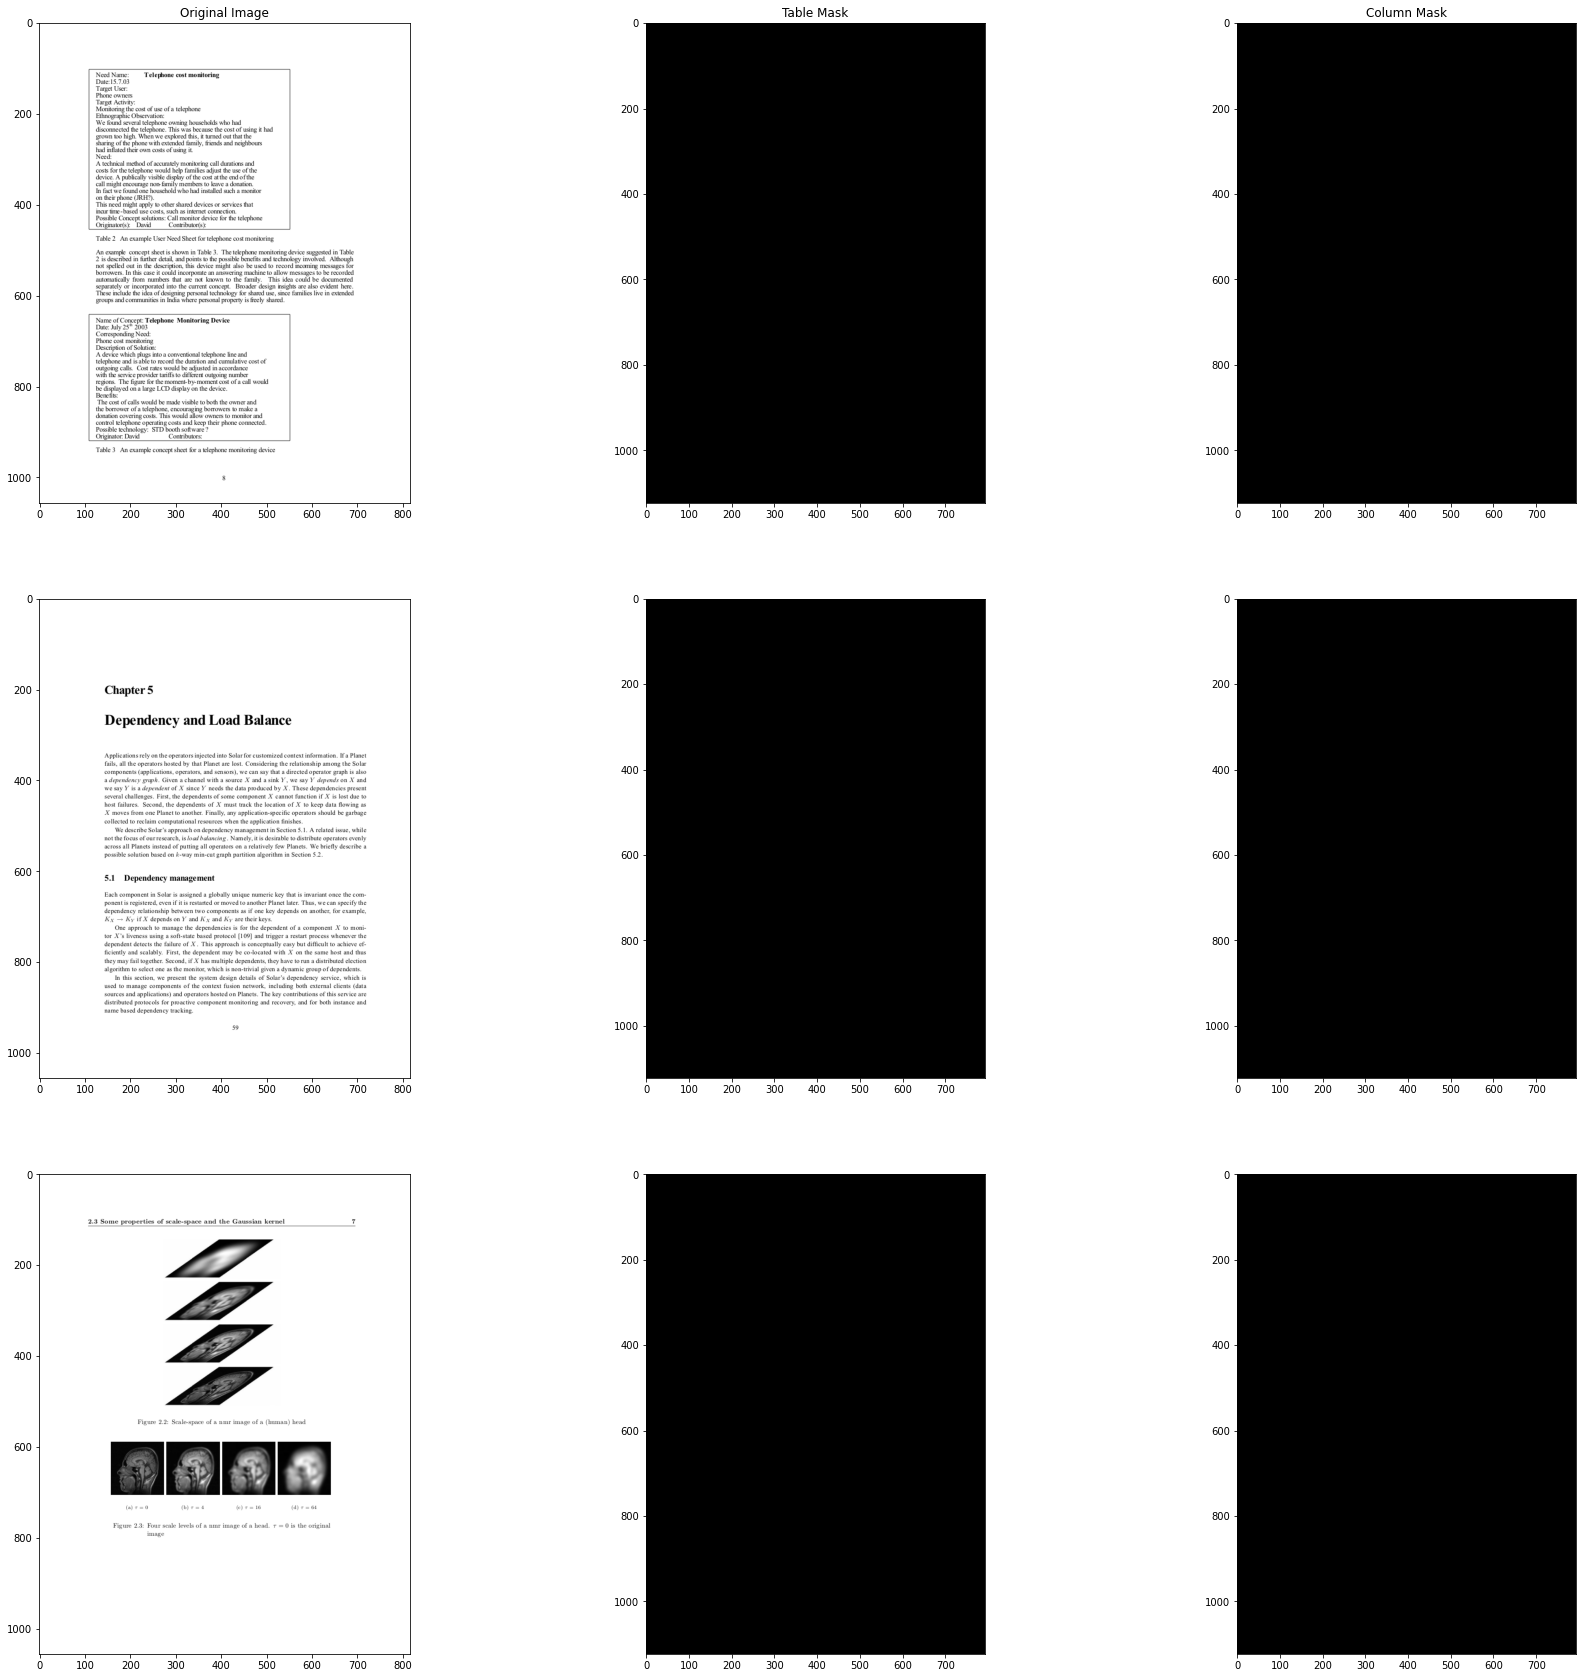

In [ ]:
display_images(zero_table[:3])

**Display Top 3 Images with more than one table**

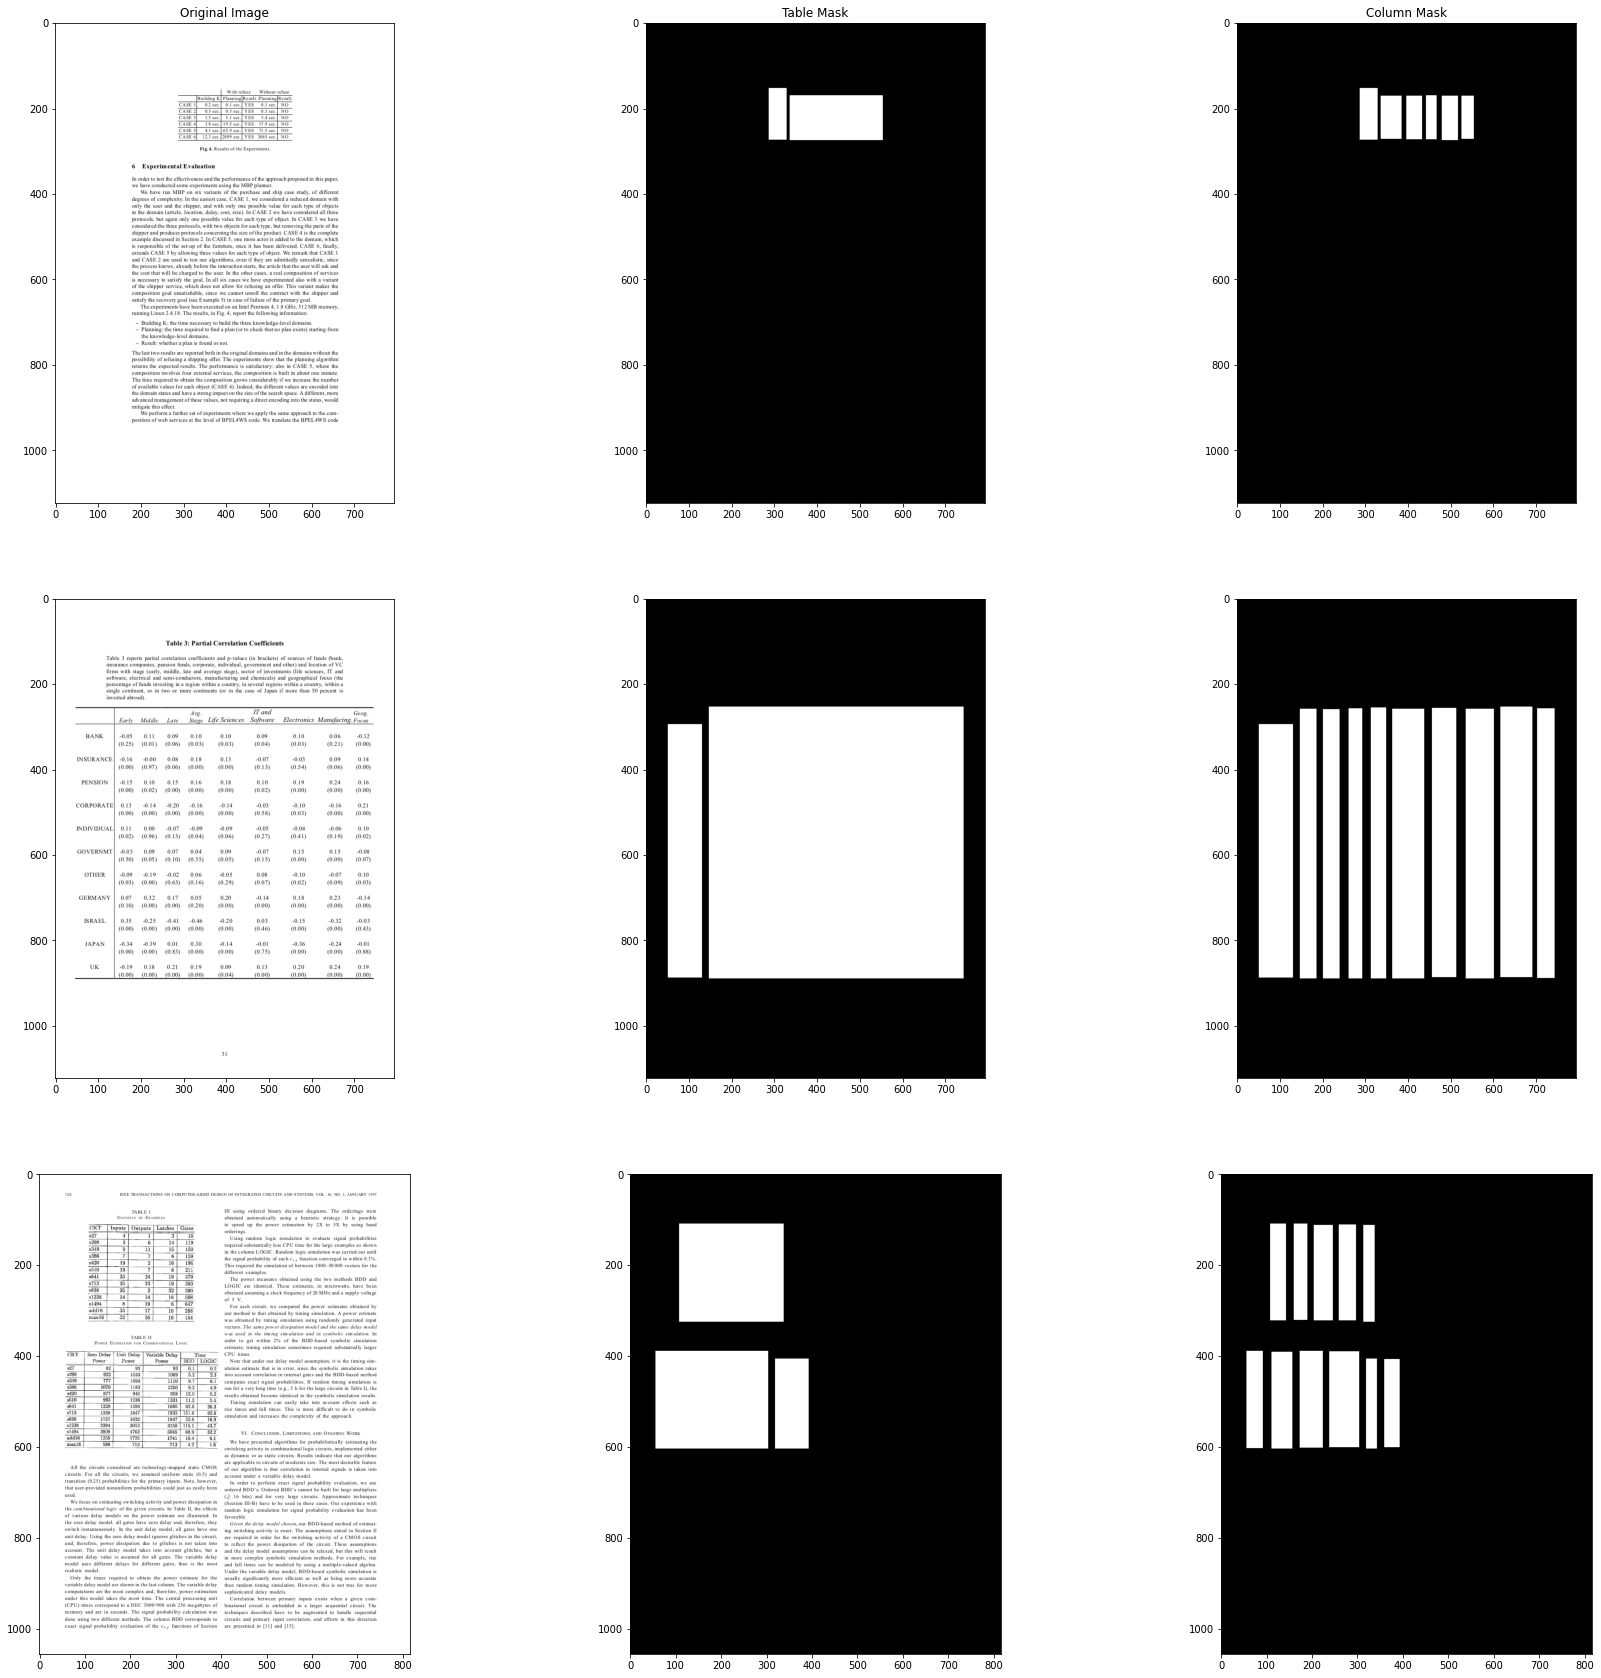

In [ ]:
display_images(more_than_one_table[:3])

In [ ]:
def get_column_number(file_ids):
    """
    Function to find number of columns in column_mask using scipy.ndimage by looking at the number of white regions.
    Usage example: 
        file_ids = ["10.1.1.1.2107_9","10.1.1.1.2076_73" ]
        get_column_number(file_ids)
        >> [(1, "10.1.1.1.2107_9"), 
            (2, "10.1.1.1.2076_73")
            ]
        args: 
            file_ids: List[int]
                List of unique file id
        return: 
            results_column: List[Tuple(int, str)]
                List of tuples where each tuple consists of number of columns and file_id
    """
    results_column = []
    for file_id in file_ids:
        column_path = f"{COLUMN_DIR}{file_id}" + ".bmp"
        column = Image.open(column_path)
        image_array=np.array(column)

        _, num_features = label(image_array)
        results_column.append((num_features, file_id))
    
    return results_column

In [ ]:
column_result = get_column_number(unique_filename)

In [ ]:
zero_column = [file_id for num_col, file_id in column_result if num_col == 0]
one_column = [file_id for num_col, file_id in column_result if num_col == 1]
more_than_one_column = [file_id for num_col, file_id in column_result if num_col > 1]

print(f"zero_column: {len(zero_column)}")
print(f"one_column: {len(one_column)}")
print(f"more_than_one_column: {len(more_than_one_column)}")

zero_column: 15
one_column: 0
more_than_one_column: 494


In [ ]:
#To find bad samples(no. of table >= 1, no. of column == 0 and no. of table == 0, no. of column >= 1) 
missing_column_mask = set(one_table + more_than_one_table) & set(zero_column)
missing_table_mask = set(zero_table) & set(one_column + more_than_one_column)
bad_sample = missing_column_mask & missing_table_mask 
print(bad_sample)

set()


In [ ]:
filename_size = []
for filename in unique_filename:
  marmot_img_path = f"{MARMOT_DIR}{filename}.bmp"
  img = Image.open(marmot_img_path)
  w,h = img.size
  filename_size.append((filename, h*w, w, h)) 

filename_size = sorted(filename_size, key=lambda element: element[1], reverse=True)
# return tuple (filename, h*w, w, h)

In [ ]:
 # find top 3 biggest img size
filename_size[:3]

[('10.1.1.1.2024_3', 892785, 795, 1123),
 ('10.1.1.6.2366_6', 892785, 795, 1123),
 ('10.1.1.100.2006_12', 892785, 795, 1123)]

In [ ]:
#top 3 smallest img size
filename_size[-3:]

[('10.1.1.192.1811_16', 580608, 672, 864),
 ('10.1.1.192.1811_6', 580608, 672, 864),
 ('10.1.1.180.567_5', 440880, 528, 835)]